# NER for constructing KG

In [1]:
!pip install spacy datasets scikit-learn
!python -m spacy download en_core_web_sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is 

## EDA and preprocessing CoNLLu04


In this experiment will be used [CoNLLU04 dataset](https://huggingface.co/datasets/DFKI-SLT/conll04) which contains extracted named entities (ORG, LOC, PER, MISC), their relations and corresponding texts. The original dataset can be found [here](https://cogcomp.seas.upenn.edu/page/resource_view/43)

In [1]:
!pip install spacy datasets scikit-learn
!python -m spacy download en_core_web_sm
!pip install sklearn_crfsuite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 31.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [1]:
from datasets import load_dataset
dataset = load_dataset("DFKI-SLT/conll04")

c:\Users\Apple\Desktop\NER for KG\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Apple\Desktop\NER for KG\.venv\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Apple\.cache\huggingface\hub\datasets--DFKI-SLT--conll04. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate

The dataset has already contained data for training, validation and testing. Let's convert all JSON data in DataFrame.

In [ ]:
df_train = dataset["train"].to_pandas()
df_test = dataset["test"].to_pandas()
df_train.head()

,entities,tokens,relations,orig_id
0,"[{'end': 5, 'start': 4, 'type': 'Loc'}, {'end'...","[Newspaper, `, Explains, ', U.S., Interests, S...","[{'head': 2, 'tail': 1, 'type': 'OrgBased_In'}]",3255
1,"[{'end': 26, 'start': 22, 'type': 'Other'}, {'...","[`, `, If, it, does, not, snow, ,, and, a, lot...","[{'head': 3, 'tail': 4, 'type': 'Work_For'}]",95
2,"[{'end': 21, 'start': 19, 'type': 'Other'}, {'...","[The, self-propelled, rig, Avco, 5, was, heade...","[{'head': 2, 'tail': 1, 'type': 'Located_In'}]",2447
3,"[{'end': 2, 'start': 0, 'type': 'Peop'}, {'end...","[Annie, Oakley, ,, also, known, as, Little, Mi...","[{'head': 0, 'tail': 3, 'type': 'Live_In'}, {'...",5284
4,"[{'end': 1, 'start': 0, 'type': 'Peop'}, {'end...","[Penry, raped, Pamela, Moseley, Carpenter, on,...","[{'head': 3, 'tail': 4, 'type': 'Located_In'}]",210


The dataset does not contain NaNs, all columns (instead of unique id) are of object data type.

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 922 entries, 0 to 921
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   entities   922 non-null    object
 1   tokens     922 non-null    object
 2   relations  922 non-null    object
 3   orig_id    922 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 28.9+ KB


Let's provide basic statistics

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import spacy
nlp = spacy.load("en_core_web_sm")

In [71]:
print("Training samples:", len(df_train))
print("Test samples:", len(df_test))

Training samples: 922
Test samples: 288


#### Texts and tokens

In [ ]:
df_train["texts"] = df_train["tokens"].apply(lambda x: " ".join(x))
df_test["texts"] = df_test["tokens"].apply(lambda x: " ".join(x))
df_train.head()

,entities,tokens,relations,orig_id,texts
0,"[{'end': 5, 'start': 4, 'type': 'Loc'}, {'end'...","[Newspaper, `, Explains, ', U.S., Interests, S...","[{'head': 2, 'tail': 1, 'type': 'OrgBased_In'}]",3255,Newspaper ` Explains ' U.S. Interests Section ...
1,"[{'end': 26, 'start': 22, 'type': 'Other'}, {'...","[`, `, If, it, does, not, snow, ,, and, a, lot...","[{'head': 3, 'tail': 4, 'type': 'Work_For'}]",95,"` ` If it does not snow , and a lot , within t..."
2,"[{'end': 21, 'start': 19, 'type': 'Other'}, {'...","[The, self-propelled, rig, Avco, 5, was, heade...","[{'head': 2, 'tail': 1, 'type': 'Located_In'}]",2447,The self-propelled rig Avco 5 was headed to sh...
3,"[{'end': 2, 'start': 0, 'type': 'Peop'}, {'end...","[Annie, Oakley, ,, also, known, as, Little, Mi...","[{'head': 0, 'tail': 3, 'type': 'Live_In'}, {'...",5284,"Annie Oakley , also known as Little Miss Sure ..."
4,"[{'end': 1, 'start': 0, 'type': 'Peop'}, {'end...","[Penry, raped, Pamela, Moseley, Carpenter, on,...","[{'head': 3, 'tail': 4, 'type': 'Located_In'}]",210,Penry raped Pamela Moseley Carpenter on Oct. 1...


Examples of texts

In [9]:
for i in df_train['texts'].head(5):
  print(i)

Newspaper ` Explains ' U.S. Interests Section Events FL1402001894 Havana Radio Reloj Network in Spanish 2100 GMT 13 Feb 94
` ` If it does not snow , and a lot , within this month we will have no water to submerge 150 , 000 hectares ( 370 , 500 acres ) of rice , ' ' said Bruno Pusterla , a top official of the Italian Agricultural Confederation .
The self-propelled rig Avco 5 was headed to shore with 14 people aboard early Monday when it capsized about 20 miles off the Louisiana coast , near Morgan City , Lifa said.
Annie Oakley , also known as Little Miss Sure Shot , was born Phoebe Ann Moses in Willowdell , Darke County , in 1860 .
Penry raped Pamela Moseley Carpenter on Oct. 15 , 1979 , in Livingston , Texas , then stabbed her to death .


Plot token count distribution

Total Tokens: 26525
Average Tokens Per Row: 28.77


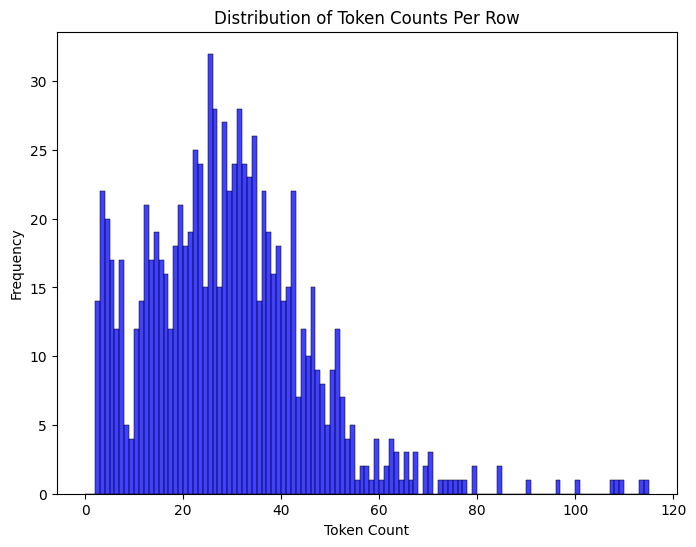

In [10]:
token_counts = [len(tokens) for tokens in df_train['tokens']]
total_tokens = sum(token_counts)
average_token_length = sum(token_counts) / len(token_counts)

print(f"Total Tokens: {total_tokens}")
print(f"Average Tokens Per Row: {average_token_length:.2f}")

plt.figure(figsize=(8, 6))
sns.histplot(token_counts, bins=range(0, max(token_counts) + 2), kde=False, color='blue')
plt.title('Distribution of Token Counts Per Row')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.show()

Total Characters: 143962
Average Characters Per Row: 156.14


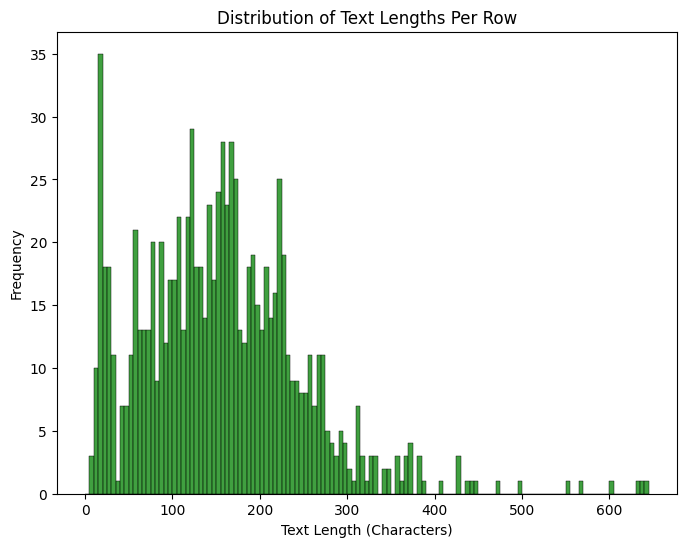

In [11]:
text_lengths = [len(text) for text in df_train['texts']]  # List of text lengths per row
total_text_length = sum(text_lengths)  # Total characters across all rows
average_text_length = sum(text_lengths) / len(text_lengths)  # Average characters per row

print(f"Total Characters: {total_text_length}")
print(f"Average Characters Per Row: {average_text_length:.2f}")

# Plot text length distribution
plt.figure(figsize=(8, 6))
sns.histplot(text_lengths, bins=range(0, max(text_lengths) + 5, 5), kde=False, color='green')
plt.title('Distribution of Text Lengths Per Row')
plt.xlabel('Text Length (Characters)')
plt.ylabel('Frequency')
plt.show()

#### Entities

In [12]:
def create_named_entities(entities, tokens):
    named_entities = []
    for entity in entities:
        start = entity['start']
        end = entity['end']
        entity_type = entity['type']
        entity_text = ' '.join(tokens[start:end])
        entry = f"{entity_text} ({start}, {end}) : {entity_type}"
        named_entities.append(entry)
    return named_entities

In [13]:
df_train['named_entities'] = df_train.apply(lambda row: create_named_entities(row['entities'], row['tokens']), axis=1)
df_train

,entities,tokens,relations,orig_id,texts,named_entities
0,"[{'end': 5, 'start': 4, 'type': 'Loc'}, {'end'...","[Newspaper, `, Explains, ', U.S., Interests, S...","[{'head': 2, 'tail': 1, 'type': 'OrgBased_In'}]",3255,Newspaper ` Explains ' U.S. Interests Section ...,"[U.S. (4, 5) : Loc, Havana (9, 10) : Loc, Radi..."
1,"[{'end': 26, 'start': 22, 'type': 'Other'}, {'...","[`, `, If, it, does, not, snow, ,, and, a, lot...","[{'head': 3, 'tail': 4, 'type': 'Work_For'}]",95,"` ` If it does not snow , and a lot , within t...","[150 , 000 hectares (22, 26) : Other, 370 , 50..."
2,"[{'end': 21, 'start': 19, 'type': 'Other'}, {'...","[The, self-propelled, rig, Avco, 5, was, heade...","[{'head': 2, 'tail': 1, 'type': 'Located_In'}]",2447,The self-propelled rig Avco 5 was headed to sh...,"[20 miles (19, 21) : Other, Louisiana (23, 24)..."
3,"[{'end': 2, 'start': 0, 'type': 'Peop'}, {'end...","[Annie, Oakley, ,, also, known, as, Little, Mi...","[{'head': 0, 'tail': 3, 'type': 'Live_In'}, {'...",5284,"Annie Oakley , also known as Little Miss Sure ...","[Annie Oakley (0, 2) : Peop, Little Miss Sure ..."
4,"[{'end': 1, 'start': 0, 'type': 'Peop'}, {'end...","[Penry, raped, Pamela, Moseley, Carpenter, on,...","[{'head': 3, 'tail': 4, 'type': 'Located_In'}]",210,Penry raped Pamela Moseley Carpenter on Oct. 1...,"[Penry (0, 1) : Peop, Pamela Moseley Carpenter..."
...,...,...,...,...,...,...
917,"[{'end': 1, 'start': 0, 'type': 'Other'}, {'en...","[An-a-one, ,, an-a-two, ,, an-a-three, billion...","[{'head': 1, 'tail': 2, 'type': 'Live_In'}]",5423,"An-a-one , an-a-two , an-a-three billion ) Tax...","[An-a-one (0, 1) : Other, Lawrence Welk (18, 2..."
918,"[{'end': 2, 'start': 1, 'type': 'Org'}, {'end'...","[Another, GE, employee, ,, attorney, Robert, C...","[{'head': 1, 'tail': 0, 'type': 'Work_For'}]",1269,"Another GE employee , attorney Robert C. Ander...","[GE (1, 2) : Org, Robert C. Anderson (5, 8) : ..."
919,"[{'end': 9, 'start': 8, 'type': 'Loc'}, {'end'...","[(, Text, ), Following, the, conclusion, of, t...","[{'head': 1, 'tail': 2, 'type': 'Live_In'}, {'...",4136,( Text ) Following the conclusion of the Genev...,"[Geneva (8, 9) : Loc, Ejup Ganic (12, 14) : Pe..."
920,"[{'end': 2, 'start': 0, 'type': 'Org'}, {'end'...","[Eaglebrook, East, opened, in, Middletown, in,...","[{'head': 0, 'tail': 1, 'type': 'OrgBased_In'}]",1452,Eaglebrook East opened in Middletown in April .,"[Eaglebrook East (0, 2) : Org, Middletown (4, ..."


In [14]:
def categorize_entities(entities_list):
    categories = {'Peop': 0, 'Loc': 0, 'Org': 0, 'Other': 0}
    for entity_str in entities_list:
        parts = entity_str.split(': ')
        if len(parts) >= 2:
            entity_type = parts[1].strip()
            if entity_type in categories:
                categories[entity_type] = 1
    return categories

In [15]:
train_ent = df_train[['orig_id', 'named_entities']]
train_ent['entity_categories'] = train_ent['named_entities'].apply(categorize_entities)
train_ent

C:\Users\Apple\AppData\Local\Temp\ipykernel_7508\3761919945.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_ent['entity_categories'] = train_ent['named_entities'].apply(categorize_entities)


,orig_id,named_entities,entity_categories
0,3255,"[U.S. (4, 5) : Loc, Havana (9, 10) : Loc, Radi...","{'Peop': 0, 'Loc': 1, 'Org': 1, 'Other': 1}"
1,95,"[150 , 000 hectares (22, 26) : Other, 370 , 50...","{'Peop': 1, 'Loc': 0, 'Org': 1, 'Other': 1}"
2,2447,"[20 miles (19, 21) : Other, Louisiana (23, 24)...","{'Peop': 1, 'Loc': 1, 'Org': 0, 'Other': 1}"
3,5284,"[Annie Oakley (0, 2) : Peop, Little Miss Sure ...","{'Peop': 1, 'Loc': 1, 'Org': 0, 'Other': 0}"
4,210,"[Penry (0, 1) : Peop, Pamela Moseley Carpenter...","{'Peop': 1, 'Loc': 1, 'Org': 0, 'Other': 1}"
...,...,...,...
917,5423,"[An-a-one (0, 1) : Other, Lawrence Welk (18, 2...","{'Peop': 1, 'Loc': 1, 'Org': 1, 'Other': 1}"
918,1269,"[GE (1, 2) : Org, Robert C. Anderson (5, 8) : ...","{'Peop': 1, 'Loc': 0, 'Org': 1, 'Other': 0}"
919,4136,"[Geneva (8, 9) : Loc, Ejup Ganic (12, 14) : Pe...","{'Peop': 1, 'Loc': 1, 'Org': 1, 'Other': 0}"
920,1452,"[Eaglebrook East (0, 2) : Org, Middletown (4, ...","{'Peop': 0, 'Loc': 1, 'Org': 1, 'Other': 0}"


In [16]:
categories = ['Peop', 'Loc', 'Org', 'Other']

encoded_ent = train_ent['entity_categories'].apply(
    lambda x: {cat: x.get(cat, 0) for cat in categories}
).apply(pd.Series)

encoded_ent = pd.concat(
    [train_ent[['orig_id']], encoded_ent],
    axis=1
)

encoded_ent

,orig_id,Peop,Loc,Org,Other
0,3255,0,1,1,1
1,95,1,0,1,1
2,2447,1,1,0,1
3,5284,1,1,0,0
4,210,1,1,0,1
...,...,...,...,...,...
917,5423,1,1,1,1
918,1269,1,0,1,0
919,4136,1,1,1,0
920,1452,0,1,1,0


Plot a bar chart

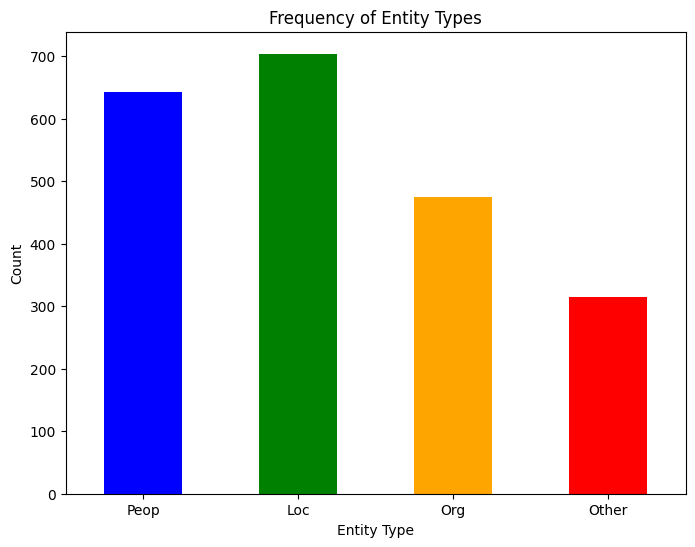

In [17]:
entity_counts = encoded_ent[['Peop', 'Loc', 'Org', 'Other']].sum()

plt.figure(figsize=(8, 6))
entity_counts.plot(kind='bar', color=['blue', 'green', 'orange', 'red'])
plt.title('Frequency of Entity Types')
plt.xlabel('Entity Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

#### Triplets

In [18]:
def create_triplets(relations, named_entities):
    triplets = []
    for relation in relations:
        head_idx = relation['head']
        tail_idx = relation['tail']
        rel_type = relation['type']

        head_entity_str = named_entities[head_idx]
        tail_entity_str = named_entities[tail_idx]

        head_text = head_entity_str.split(' (', 1)[0].strip()
        tail_text = tail_entity_str.split(' (', 1)[0].strip()

        triplet = f"{head_text}|{rel_type}|{tail_text}"
        triplets.append(triplet)
    return triplets

In [19]:
df_train['triplets'] = df_train.apply(lambda row: create_triplets(row['relations'], row['named_entities']), axis=1)
df_train

,entities,tokens,relations,orig_id,texts,named_entities,triplets
0,"[{'end': 5, 'start': 4, 'type': 'Loc'}, {'end'...","[Newspaper, `, Explains, ', U.S., Interests, S...","[{'head': 2, 'tail': 1, 'type': 'OrgBased_In'}]",3255,Newspaper ` Explains ' U.S. Interests Section ...,"[U.S. (4, 5) : Loc, Havana (9, 10) : Loc, Radi...",[Radio Reloj Network|OrgBased_In|Havana]
1,"[{'end': 26, 'start': 22, 'type': 'Other'}, {'...","[`, `, If, it, does, not, snow, ,, and, a, lot...","[{'head': 3, 'tail': 4, 'type': 'Work_For'}]",95,"` ` If it does not snow , and a lot , within t...","[150 , 000 hectares (22, 26) : Other, 370 , 50...",[Bruno Pusterla|Work_For|Italian Agricultural ...
2,"[{'end': 21, 'start': 19, 'type': 'Other'}, {'...","[The, self-propelled, rig, Avco, 5, was, heade...","[{'head': 2, 'tail': 1, 'type': 'Located_In'}]",2447,The self-propelled rig Avco 5 was headed to sh...,"[20 miles (19, 21) : Other, Louisiana (23, 24)...",[Morgan City|Located_In|Louisiana]
3,"[{'end': 2, 'start': 0, 'type': 'Peop'}, {'end...","[Annie, Oakley, ,, also, known, as, Little, Mi...","[{'head': 0, 'tail': 3, 'type': 'Live_In'}, {'...",5284,"Annie Oakley , also known as Little Miss Sure ...","[Annie Oakley (0, 2) : Peop, Little Miss Sure ...","[Annie Oakley|Live_In|Willowdell , Darke Count..."
4,"[{'end': 1, 'start': 0, 'type': 'Peop'}, {'end...","[Penry, raped, Pamela, Moseley, Carpenter, on,...","[{'head': 3, 'tail': 4, 'type': 'Located_In'}]",210,Penry raped Pamela Moseley Carpenter on Oct. 1...,"[Penry (0, 1) : Peop, Pamela Moseley Carpenter...",[Livingston|Located_In|Texas]
...,...,...,...,...,...,...,...
917,"[{'end': 1, 'start': 0, 'type': 'Other'}, {'en...","[An-a-one, ,, an-a-two, ,, an-a-three, billion...","[{'head': 1, 'tail': 2, 'type': 'Live_In'}]",5423,"An-a-one , an-a-two , an-a-three billion ) Tax...","[An-a-one (0, 1) : Other, Lawrence Welk (18, 2...",[Lawrence Welk|Live_In|North Dakota]
918,"[{'end': 2, 'start': 1, 'type': 'Org'}, {'end'...","[Another, GE, employee, ,, attorney, Robert, C...","[{'head': 1, 'tail': 0, 'type': 'Work_For'}]",1269,"Another GE employee , attorney Robert C. Ander...","[GE (1, 2) : Org, Robert C. Anderson (5, 8) : ...",[Robert C. Anderson|Work_For|GE]
919,"[{'end': 9, 'start': 8, 'type': 'Loc'}, {'end'...","[(, Text, ), Following, the, conclusion, of, t...","[{'head': 1, 'tail': 2, 'type': 'Live_In'}, {'...",4136,( Text ) Following the conclusion of the Genev...,"[Geneva (8, 9) : Loc, Ejup Ganic (12, 14) : Pe...",[Ejup Ganic|Live_In|Federation of Bosnia-Herze...
920,"[{'end': 2, 'start': 0, 'type': 'Org'}, {'end'...","[Eaglebrook, East, opened, in, Middletown, in,...","[{'head': 0, 'tail': 1, 'type': 'OrgBased_In'}]",1452,Eaglebrook East opened in Middletown in April .,"[Eaglebrook East (0, 2) : Org, Middletown (4, ...",[Eaglebrook East|OrgBased_In|Middletown]


## Classical ML Method for NER task: Conditional Random Fields (CRF)

CRF is a discriminative probabilistic model designed for sequence labeling tasks like NER. Unlike generative models (e.g., Hidden Markov Models), CRFs directly model the conditional probability P(Y∣X), where Y is the label sequence and X is the input sequence. This allows CRFs to leverage complex feature interactions and avoid the label bias problem. More info about CRF: [[Lafferty et al.2001]](https://www.researchgate.net/publication/2529190_Conditional_Random_Fields_Probabilistic_Models_for_Segmenting_and_Labeling_Sequence_Data)

The conditional probability of a label sequence \( Y = (y_1, y_2, ..., y_n) \) given an input sequence \( X = (x_1, x_2, ..., x_n) \) is defined as:

$$P(Y|X; \theta) = \frac{1}{Z(X)} \exp \left( \sum_{i=1}^n \sum_k \theta_k^{(s)} f_k^{(s)}(y_i, x_i, i) + \sum_{i=1}^{n-1} \sum_k \theta_k^{(t)} f_k^{(t)}(y_i, y_{i+1}, x_i, x_{i+1}, i) \right)$$


Where:
- theta: Parameters (feature weights) learned during training
- Z(X): Normalization term (partition function), ensuring probabilities sum to 1
- f^(s): State (vertex) features which are associated with individual positions *i* and labels *y_i*
- f^(t): Transition (edge) features which are associated with transitions between labels *y_i* and *y_(i+1)*

In the experiment parameters from [this article](https://arxiv.org/pdf/1404.5367#page=3.43) was used:
- State features:
  - bias
  - POS
  - lower-case
  - its capitalization pattern;
  - whether it is punctuation
  - 4-character prefixes and suffixes;
  - character n-grams from length 2 to 5;

<b> + Neighborhood features </b>

- Transition features: bio-tagging tokens with named entities (features are specified through CRF model hyperparameters)

Let's modify current dataset and prepare data for training

### Extracting token features

In [20]:
def add_pos_tags(row):
    tokens = row['tokens']
    doc = nlp(' '.join(tokens))
    pos_tags = [token.pos_ for token in doc]

    row['pos_tags'] = pos_tags
    return row

In [21]:
df_train = df_train.apply(add_pos_tags, axis=1)
df_train

,entities,tokens,relations,orig_id,texts,named_entities,triplets,pos_tags
0,"[{'end': 5, 'start': 4, 'type': 'Loc'}, {'end'...","[Newspaper, `, Explains, ', U.S., Interests, S...","[{'head': 2, 'tail': 1, 'type': 'OrgBased_In'}]",3255,Newspaper ` Explains ' U.S. Interests Section ...,"[U.S. (4, 5) : Loc, Havana (9, 10) : Loc, Radi...",[Radio Reloj Network|OrgBased_In|Havana],"[NOUN, PUNCT, VERB, PUNCT, PROPN, PROPN, PROPN..."
1,"[{'end': 26, 'start': 22, 'type': 'Other'}, {'...","[`, `, If, it, does, not, snow, ,, and, a, lot...","[{'head': 3, 'tail': 4, 'type': 'Work_For'}]",95,"` ` If it does not snow , and a lot , within t...","[150 , 000 hectares (22, 26) : Other, 370 , 50...",[Bruno Pusterla|Work_For|Italian Agricultural ...,"[PUNCT, PUNCT, SCONJ, PRON, AUX, PART, VERB, P..."
2,"[{'end': 21, 'start': 19, 'type': 'Other'}, {'...","[The, self-propelled, rig, Avco, 5, was, heade...","[{'head': 2, 'tail': 1, 'type': 'Located_In'}]",2447,The self-propelled rig Avco 5 was headed to sh...,"[20 miles (19, 21) : Other, Louisiana (23, 24)...",[Morgan City|Located_In|Louisiana],"[DET, NOUN, PUNCT, VERB, NOUN, PROPN, NUM, AUX..."
3,"[{'end': 2, 'start': 0, 'type': 'Peop'}, {'end...","[Annie, Oakley, ,, also, known, as, Little, Mi...","[{'head': 0, 'tail': 3, 'type': 'Live_In'}, {'...",5284,"Annie Oakley , also known as Little Miss Sure ...","[Annie Oakley (0, 2) : Peop, Little Miss Sure ...","[Annie Oakley|Live_In|Willowdell , Darke Count...","[PROPN, PROPN, PUNCT, ADV, VERB, ADP, PROPN, P..."
4,"[{'end': 1, 'start': 0, 'type': 'Peop'}, {'end...","[Penry, raped, Pamela, Moseley, Carpenter, on,...","[{'head': 3, 'tail': 4, 'type': 'Located_In'}]",210,Penry raped Pamela Moseley Carpenter on Oct. 1...,"[Penry (0, 1) : Peop, Pamela Moseley Carpenter...",[Livingston|Located_In|Texas],"[PROPN, VERB, PROPN, PROPN, PROPN, ADP, PROPN,..."
...,...,...,...,...,...,...,...,...
917,"[{'end': 1, 'start': 0, 'type': 'Other'}, {'en...","[An-a-one, ,, an-a-two, ,, an-a-three, billion...","[{'head': 1, 'tail': 2, 'type': 'Live_In'}]",5423,"An-a-one , an-a-two , an-a-three billion ) Tax...","[An-a-one (0, 1) : Other, Lawrence Welk (18, 2...",[Lawrence Welk|Live_In|North Dakota],"[X, PUNCT, DET, PUNCT, NUM, PUNCT, DET, PUNCT,..."
918,"[{'end': 2, 'start': 1, 'type': 'Org'}, {'end'...","[Another, GE, employee, ,, attorney, Robert, C...","[{'head': 1, 'tail': 0, 'type': 'Work_For'}]",1269,"Another GE employee , attorney Robert C. Ander...","[GE (1, 2) : Org, Robert C. Anderson (5, 8) : ...",[Robert C. Anderson|Work_For|GE],"[DET, PROPN, NOUN, PUNCT, NOUN, PROPN, PROPN, ..."
919,"[{'end': 9, 'start': 8, 'type': 'Loc'}, {'end'...","[(, Text, ), Following, the, conclusion, of, t...","[{'head': 1, 'tail': 2, 'type': 'Live_In'}, {'...",4136,( Text ) Following the conclusion of the Genev...,"[Geneva (8, 9) : Loc, Ejup Ganic (12, 14) : Pe...",[Ejup Ganic|Live_In|Federation of Bosnia-Herze...,"[PUNCT, NOUN, PUNCT, VERB, DET, NOUN, ADP, DET..."
920,"[{'end': 2, 'start': 0, 'type': 'Org'}, {'end'...","[Eaglebrook, East, opened, in, Middletown, in,...","[{'head': 0, 'tail': 1, 'type': 'OrgBased_In'}]",1452,Eaglebrook East opened in Middletown in April .,"[Eaglebrook East (0, 2) : Org, Middletown (4, ...",[Eaglebrook East|OrgBased_In|Middletown],"[PROPN, PROPN, VERB, ADP, PROPN, ADP, PROPN, P..."


In [22]:
def get_char_ngrams(token, min_n=2, max_n=5):
    ngrams = set()
    for n in range(min_n, max_n+1):
        for i in range(len(token) - n + 1):
            ngrams.add(token[i:i+n])
    return ngrams

In [23]:
def extract_features(df_row, i):
    tokens = df_row['tokens']
    pos_tags = df_row['pos_tags']

    token = tokens[i]
    pos = pos_tags[i]

    features = {
        'bias': 1.0,
        'pos': pos,
        'word.lower()': token.lower(),
        'is_capitalized': token[0].isupper() if len(token) > 0 else False,
        'is_all_caps': token.isupper(),
        'word.is_punctuation': token in ['.', ',', ';', '?', '!'],
        'prefix4': token[:4] if len(token) >= 4 else token,
        'suffix4': token[-4:] if len(token) >= 4 else token,
        'char_ngrams': get_char_ngrams(token),
    }

    # Neighborhood features
    if i > 0:
        prev_token = tokens[i-1]
        prev_pos = pos_tags[i-1]
        features.update({
            '-1:word.lower()': prev_token.lower(),
            '-1:pos': prev_pos if len(prev_pos) >= 2 else prev_pos,
        })
    else:
        features['BOS'] = True

    if i < len(tokens) - 1:
        next_token = tokens[i+1]
        next_pos = pos_tags[i+1]
        features.update({
            '+1:word.lower()': next_token.lower(),
            '+1:pos': next_pos if len(next_pos) >= 2 else next_pos,
        })
    else:
        features['EOS'] = True

    return features

### BIO-tagging

In [24]:
def generate_bio_tags(tokens, entities):
    bio_tags = ['O'] * len(tokens)
    for entity in entities:
        start = entity['start']
        end = entity['end']
        typ = entity['type']
        if start < len(bio_tags):
            bio_tags[start] = f'B-{typ}'
        for i in range(start + 1, end):
            if i < len(bio_tags):
                bio_tags[i] = f'I-{typ}'
    return bio_tags

In [25]:
df_train['bio_tags'] = df_train.apply(lambda row: generate_bio_tags(row['tokens'], row['entities']), axis=1)
df_train

,entities,tokens,relations,orig_id,texts,named_entities,triplets,pos_tags,bio_tags
0,"[{'end': 5, 'start': 4, 'type': 'Loc'}, {'end'...","[Newspaper, `, Explains, ', U.S., Interests, S...","[{'head': 2, 'tail': 1, 'type': 'OrgBased_In'}]",3255,Newspaper ` Explains ' U.S. Interests Section ...,"[U.S. (4, 5) : Loc, Havana (9, 10) : Loc, Radi...",[Radio Reloj Network|OrgBased_In|Havana],"[NOUN, PUNCT, VERB, PUNCT, PROPN, PROPN, PROPN...","[O, O, O, O, B-Loc, O, O, O, O, B-Loc, B-Org, ..."
1,"[{'end': 26, 'start': 22, 'type': 'Other'}, {'...","[`, `, If, it, does, not, snow, ,, and, a, lot...","[{'head': 3, 'tail': 4, 'type': 'Work_For'}]",95,"` ` If it does not snow , and a lot , within t...","[150 , 000 hectares (22, 26) : Other, 370 , 50...",[Bruno Pusterla|Work_For|Italian Agricultural ...,"[PUNCT, PUNCT, SCONJ, PRON, AUX, PART, VERB, P...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,"[{'end': 21, 'start': 19, 'type': 'Other'}, {'...","[The, self-propelled, rig, Avco, 5, was, heade...","[{'head': 2, 'tail': 1, 'type': 'Located_In'}]",2447,The self-propelled rig Avco 5 was headed to sh...,"[20 miles (19, 21) : Other, Louisiana (23, 24)...",[Morgan City|Located_In|Louisiana],"[DET, NOUN, PUNCT, VERB, NOUN, PROPN, NUM, AUX...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
3,"[{'end': 2, 'start': 0, 'type': 'Peop'}, {'end...","[Annie, Oakley, ,, also, known, as, Little, Mi...","[{'head': 0, 'tail': 3, 'type': 'Live_In'}, {'...",5284,"Annie Oakley , also known as Little Miss Sure ...","[Annie Oakley (0, 2) : Peop, Little Miss Sure ...","[Annie Oakley|Live_In|Willowdell , Darke Count...","[PROPN, PROPN, PUNCT, ADV, VERB, ADP, PROPN, P...","[B-Peop, I-Peop, O, O, O, O, B-Peop, I-Peop, I..."
4,"[{'end': 1, 'start': 0, 'type': 'Peop'}, {'end...","[Penry, raped, Pamela, Moseley, Carpenter, on,...","[{'head': 3, 'tail': 4, 'type': 'Located_In'}]",210,Penry raped Pamela Moseley Carpenter on Oct. 1...,"[Penry (0, 1) : Peop, Pamela Moseley Carpenter...",[Livingston|Located_In|Texas],"[PROPN, VERB, PROPN, PROPN, PROPN, ADP, PROPN,...","[B-Peop, O, B-Peop, I-Peop, I-Peop, O, B-Other..."
...,...,...,...,...,...,...,...,...,...
917,"[{'end': 1, 'start': 0, 'type': 'Other'}, {'en...","[An-a-one, ,, an-a-two, ,, an-a-three, billion...","[{'head': 1, 'tail': 2, 'type': 'Live_In'}]",5423,"An-a-one , an-a-two , an-a-three billion ) Tax...","[An-a-one (0, 1) : Other, Lawrence Welk (18, 2...",[Lawrence Welk|Live_In|North Dakota],"[X, PUNCT, DET, PUNCT, NUM, PUNCT, DET, PUNCT,...","[B-Other, O, O, O, O, O, O, O, O, O, O, O, O, ..."
918,"[{'end': 2, 'start': 1, 'type': 'Org'}, {'end'...","[Another, GE, employee, ,, attorney, Robert, C...","[{'head': 1, 'tail': 0, 'type': 'Work_For'}]",1269,"Another GE employee , attorney Robert C. Ander...","[GE (1, 2) : Org, Robert C. Anderson (5, 8) : ...",[Robert C. Anderson|Work_For|GE],"[DET, PROPN, NOUN, PUNCT, NOUN, PROPN, PROPN, ...","[O, B-Org, O, O, O, B-Peop, I-Peop, I-Peop, O,..."
919,"[{'end': 9, 'start': 8, 'type': 'Loc'}, {'end'...","[(, Text, ), Following, the, conclusion, of, t...","[{'head': 1, 'tail': 2, 'type': 'Live_In'}, {'...",4136,( Text ) Following the conclusion of the Genev...,"[Geneva (8, 9) : Loc, Ejup Ganic (12, 14) : Pe...",[Ejup Ganic|Live_In|Federation of Bosnia-Herze...,"[PUNCT, NOUN, PUNCT, VERB, DET, NOUN, ADP, DET...","[O, O, O, O, O, O, O, O, B-Loc, O, O, O, B-Peo..."
920,"[{'end': 2, 'start': 0, 'type': 'Org'}, {'end'...","[Eaglebrook, East, opened, in, Middletown, in,...","[{'head': 0, 'tail': 1, 'type': 'OrgBased_In'}]",1452,Eaglebrook East opened in Middletown in April .,"[Eaglebrook East (0, 2) : Org, Middletown (4, ...",[Eaglebrook East|OrgBased_In|Middletown],"[PROPN, PROPN, VERB, ADP, PROPN, ADP, PROPN, P...","[B-Org, I-Org, O, O, B-Loc, O, O, O]"


## Training

In [26]:
def sent2features(df_row):
    tokens = df_row['tokens']
    return [extract_features(df_row, i) for i in range(len(tokens))]

def sent2labels(df_row):
    return df_row['bio_tags']

In [27]:
X_train = df_train.apply(sent2features, axis=1).tolist()
y_train = df_train.apply(sent2labels, axis=1).tolist()

In [28]:
from sklearn_crfsuite import CRF
from sklearn_crfsuite.metrics import flat_f1_score

crf = CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
)

crf.fit(X_train, y_train)

CRF(algorithm='lbfgs', c1=0.1, c2=0.1, max_iterations=100)

Let's preprocess test data for evaluating results

In [ ]:
df_test['bio_tags'] = df_test.apply(lambda row: generate_bio_tags(row['tokens'], row['entities']), axis=1)
df_test = df_test.apply(add_pos_tags, axis=1)

In [ ]:
X_test = df_test.apply(sent2features, axis=1).tolist()
y_test = df_test.apply(sent2labels, axis=1).tolist()

y_pred = crf.predict(X_test)

## Evaluating

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV

In [65]:
y_test_flat = [label for sentence in y_test for label in sentence]
y_pred_flat = [label for sentence in y_pred for label in sentence]

labels = list(crf.classes_)


report_dict = classification_report(y_test_flat, y_pred_flat, labels=labels, digits=4, output_dict=True)

print("Classification Report:")
print(classification_report(y_test_flat, y_pred_flat, labels=labels, digits=4))

Classification Report:
              precision    recall  f1-score   support

           O     0.9698    0.9773    0.9736      6313
       B-Loc     0.8600    0.8197    0.8393       427
       B-Org     0.7967    0.7323    0.7632       198
       I-Org     0.7138    0.7967    0.7529       241
     B-Other     0.8100    0.6090    0.6953       133
     I-Other     0.8077    0.6462    0.7179       130
      B-Peop     0.8018    0.8193    0.8105       321
      I-Peop     0.8389    0.9458    0.8892       369
       I-Loc     0.8155    0.6716    0.7366       204

    accuracy                         0.9322      8336
   macro avg     0.8238    0.7798    0.7976      8336
weighted avg     0.9316    0.9322    0.9311      8336



In [78]:
macro_precision = precision_score(y_test_flat, y_pred_flat, average='macro')
macro_recall = recall_score(y_test_flat, y_pred_flat, average='macro')
macro_f1 = f1_score(y_test_flat, y_pred_flat, average='macro')

print(f"Macro-precision: {macro_precision:.4f}")
print(f"Macro-recall: {macro_recall:.4f}")
print(f"Macro-F1: {macro_f1:.4f}")

Macro-precision: 0.8238
Macro-recall: 0.7798
Macro-F1: 0.7976


Plot the confusion matrix

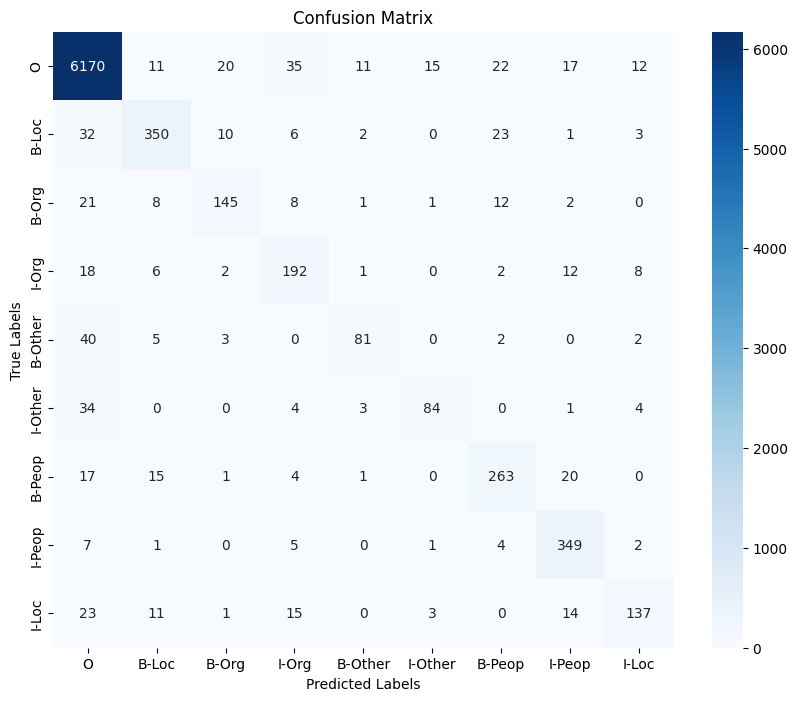

In [57]:
cm = confusion_matrix(y_test_flat, y_pred_flat, labels=labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

Now let's use cross-validation to find best parameters for the model

In [72]:
params = {
    'c1': [0.01, 0.1, 1.0],
    'c2': [0.01, 0.1, 1.0],
    'algorithm': ['lbfgs', 'l2sgd'],
    'max_iterations': [50, 100, 200]
}

grid_search = GridSearchCV(
    estimator=CRF(),
    param_grid=params,
    cv=3,
    scoring='f1_macro'
)
grid_search.fit(X_train, y_train)

best_crf = grid_search.best_estimator_

c:\Users\Apple\Desktop\NER for KG\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Apple\Desktop\NER for KG\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Apple\Desktop\NER for KG\.venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Apple\Desktop\NER for KG\.venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
              

In [76]:
y_pred_test = best_crf.predict(X_test)

print("\nBest params:")
print(grid_search.best_params_)

f1_test = flat_f1_score(y_test, y_pred_test, average='macro')
print(f"\nMacro-F1: {f1_test:.3f}")


Best params:
{'algorithm': 'lbfgs', 'c1': 0.01, 'c2': 0.01, 'max_iterations': 50}

Macro-F1: 0.804
